<a href="https://colab.research.google.com/github/vivivicdjdk/machine/blob/main/9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

**IMDB 리뷰 데이터셋**

유명한 영화 데이터베이스인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋

**자연어 처리** 컴퓨터를 사용해 인간의 언어를 처리하는 분야

음성 인식, 기계 번역, 감성 분석 등

iMDB 리뷰를 감상평에 따라 분류하는 작업은 감성 분석에 해당

**말뭉치** 자연어 처리 분야에서 부르는 훈련 데이터

텍스트 자체를 신경망에 전달하는 것은 아님

합성곱 신경망에서 이미지를 다룰 때는 이미지가 정수 픽셀값으로 이루어져 있어 특별한 변환을 하지 않았지만,

텍스트 데이터의 경우 단어를 전달하는 일반적인 방법은 데이터에 등장하는 단어마다 고유한 전수를 부여해 숫자 데이터를 바꿈

예를 들어, He를 10으로 매핑

일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리

이렇게 분리된 단어를 **토큰**이라고 부름

텐서플로에는 이미 정수로 바꾼 데이터가 포

In [2]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=300)

In [3]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


1차원 배열임

IMDB 리뷰 텍스트는 길이가 제각각이기 때문에

고정 크기의 2차원 배열에 담기 보다는 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있음

즉, 이 데이터는 개별 리뷰를 담은 파이썬 리스트 객체로 이루어진 넘파이 배열

In [4]:
# 첫 번째 리뷰의 길이는 218개의 토큰으로 구성
print(len(train_input[0]))

218


In [5]:
# 두 번째 리뷰의 길
print(len(train_input[1]))

189


In [ ]:
#첫 번째 리뷰에 담긴 내용 출력
print(train_input[0])

In [6]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


해결할 문제는 리뷰가 긍정인지 부정인지 판단하는 것

그러면 이진 분류 문제로 볼 수 있으므로 타깃값이 0(부정)과 1(긍정)으로 나누어짐

In [7]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

각 리뷰의 길이를 계산해 넘파이 배열에 저장

평균 리뷰 길이, 가장 짧은 리뷰 길이, 가장 긴 리뷰 길이

In [9]:
import numpy as np

lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


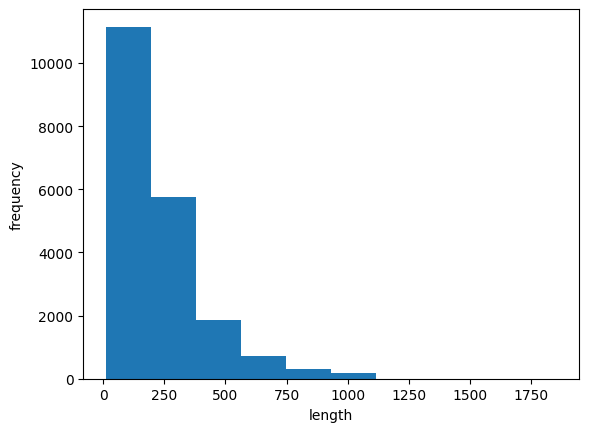

In [10]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

이 리뷰 길이 데이터는 한쪽에 치우친 분포를 보임

대부분의 리뷰 길이는 300 미만

**pad_suquences()** 시퀀스 데이터의 길이를 맞추는 함수

기본으로 maxlen보다 긴 시퀀스의 앞부분을 자

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # train_input의 길이를 100으로 맞춤
print(train_seq.shape)

(20000, 100)


In [13]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [14]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [15]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94 205   2  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

**순환 신경망 만들기**

In [17]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 300)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

지금까지 보았던 구성과 매우 비슷

SimpleRNN 클래스를 사용

* 첫 번째 매개변수는 사용할 뉴런의 개수를 지정

* SimpleRNN 클래스의 활성화 함수 기본값은 'tanh'로 하이퍼볼릭 탄젠트 함수를 사용

keras.utils 패키지 아래에 있는 **to_categorical()** 함수에서는 정수 배열을 입력하면 자동으로 원-핫 인코딩된 배열을 반환

In [18]:
train_oh = keras.utils.to_categorical(train_seq)

In [19]:
print(train_oh.shape)

(20000, 100, 300)


첫 번째 샘플의 첫 번째 토큰 10이 잘 인코딩되었는지 확인

In [20]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


열한 번째 원소가 1인 것을 확인

In [ ]:
# 모든 원소의 값을 더해서 1이 되는지 확인
print(np.sum(train_oh[0][0]))

In [21]:
val_oh = keras.utils.to_categorical(val_seq)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 2472      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2481 (9.69 KB)
Trainable params: 2481 (9.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**순환 신경망 훈련하기**

In [23]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 59ms/step - loss: 0.6994 - accuracy: 0.5053 - val_loss: 0.6966 - val_accuracy: 0.5084
Epoch 2/100
  5/313 [..............................] - ETA: 8s - loss: 0.6927 - accuracy: 0.5437

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 14s 46ms/step - loss: 0.6933 - accuracy: 0.5218 - val_loss: 0.6915 - val_accuracy: 0.5290
Epoch 3/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6832 - accuracy: 0.5555 - val_loss: 0.6734 - val_accuracy: 0.5830
Epoch 4/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6597 - accuracy: 0.6170 - val_loss: 0.6554 - val_accuracy: 0.6282
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6422 - accuracy: 0.6492 - val_loss: 0.6423 - val_accuracy: 0.6420
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6270 - accuracy: 0.6680 - val_loss: 0.6256 - val_accuracy: 0.6698
Epoch 7/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6133 - accuracy: 0.6827 - val_loss: 0.6118 - val_accuracy: 0.6860
Epoch 8/100
313/313 [==============================] - 15s 49ms/step - loss: 0.5999 - accuracy: 0.6978 - val_loss: 0.6016 - val_accuracy: 0.69

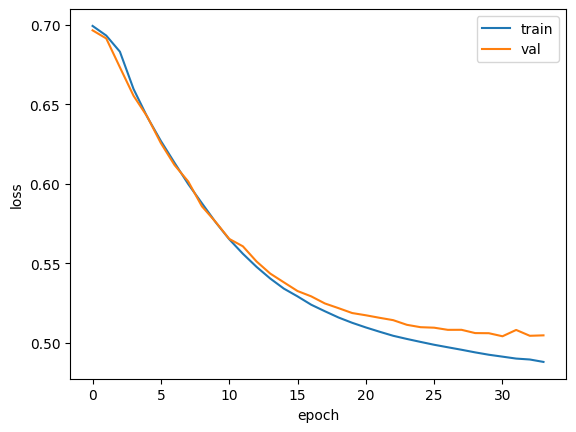

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

**단어 임베딩을 사용하기**

**단어 임베딩** 각 단어를 고정된 크기의 실수 벡터로 바꾸어 줌

원-핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 발휘

keras.layers 패키지 아래 **Embaddilng**클래스로 제공

처음에는 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습

앞서 원-핫 인코딩은 샘플 하나를 300차원으로 늘렸기 때문에 (100,) 크기의 샘플이 (100,300)으로 커짐

임베딩도 (100,)크기의 샘플을 (100,20)과 같이 2차원 배열로 늘림

하지만 훨씬 작은 크기로도 단어를 잘 표

In [25]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(300, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           4800      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5009 (19.57 KB)
Trainable params: 5009 (19.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# 모델 훈련 과정은 이전과 동일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 11s 33ms/step - loss: 0.6937 - accuracy: 0.5199 - val_loss: 0.6819 - val_accuracy: 0.5742
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6728 - accuracy: 0.6016 - val_loss: 0.6632 - val_accuracy: 0.6352
Epoch 3/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6529 - accuracy: 0.6560 - val_loss: 0.6447 - val_accuracy: 0.6650
Epoch 4/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6338 - accuracy: 0.6859 - val_loss: 0.6273 - val_accuracy: 0.6864
Epoch 5/100
313/313 [==============================] - 8s 25ms/step - loss: 0.6154 - accuracy: 0.7054 - val_loss: 0.6115 - val_accuracy: 0.7030
Epoch 6/100
313/313 [==============================] - 10s 32ms/step - loss: 0.5997 - accuracy: 0.7189 - val_loss: 0.5965 - val_accuracy: 0.7128
Epoch 7/100
313/313 [==============================] - 8s 25ms/step - loss: 0.5843 - accuracy: 0.7285 - val_loss: 0.5804 - val_accur

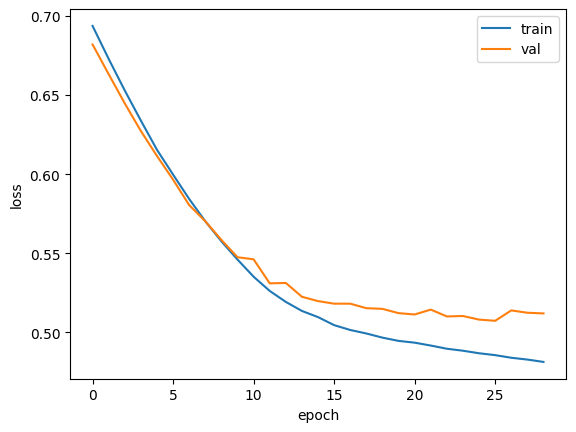

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()